In [1]:
import os
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2')
from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader
import matplotlib.pyplot as plt
import tflite_model_maker
from PIL import Image, ImageOps

2021-11-07 16:35:43.845313: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-07 16:35:43.845345: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
image_path = 'bhavika_data/'

In [3]:
data = DataLoader.from_folder(image_path)

INFO:tensorflow:Load image with size: 327, num_label: 2, labels: fall, no-fall.


2021-11-07 16:35:46.782860: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-07 16:35:46.782884: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-07 16:35:46.782903: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bhavika-ML): /proc/driver/nvidia/version does not exist
2021-11-07 16:35:46.783239: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
train_data, validation_data = data.split(0.8)

In [5]:
model = image_classifier.create(train_data, model_spec='efficientnet_lite0', validation_data=validation_data, epochs=5, batch_size=8)
print(model)

INFO:tensorflow:Retraining the models...


2021-11-07 16:36:09.169921: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              3413024   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 3,415,586
Trainable params: 2,562
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/5


/home/bhavika/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


32/32 [==============================] - 28s 824ms/step - loss: 0.7842 - accuracy: 0.6250 - val_loss: 0.7170 - val_accuracy: 0.7344
Epoch 2/5
32/32 [==============================] - 30s 969ms/step - loss: 0.4769 - accuracy: 0.8398 - val_loss: 0.9231 - val_accuracy: 0.7188
Epoch 3/5
32/32 [==============================] - 29s 920ms/step - loss: 0.4378 - accuracy: 0.8633 - val_loss: 0.6859 - val_accuracy: 0.8281
Epoch 4/5
32/32 [==============================] - 29s 940ms/step - loss: 0.3862 - accuracy: 0.9062 - val_loss: 0.5129 - val_accuracy: 0.7656
Epoch 5/5
32/32 [==============================] - 25s 811ms/step - loss: 0.3386 - accuracy: 0.9414 - val_loss: 0.5095 - val_accuracy: 0.8281


In [7]:
model.export(export_dir='ai_models', tflite_filename='john-custom-transfer-learned-fall-detect-model-efficientnet_lite.tflite')

INFO:tensorflow:Assets written to: /tmp/tmpcironj4j/assets


INFO:tensorflow:Assets written to: /tmp/tmpcironj4j/assets
2021-11-07 16:41:26.748529: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2021-11-07 16:41:26.748700: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-11-07 16:41:26.781690: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: Graph size after: 913 nodes (656), 923 edges (664), time = 17.393ms.
  function_optimizer: function_optimizer did nothing. time = 0.448ms.

2021-11-07 16:41:27.507539: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2021-11-07 16:41:27.507574: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmpdd__n6_t/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmpdd__n6_t/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ai_models/john-custom-transfer-learned-fall-detect-model-efficientnet_lite.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ai_models/john-custom-transfer-learned-fall-detect-model-efficientnet_lite.tflite


# Model Inference

In [8]:
def thumbnail(image=None, desired_size=None):
    """Resizes original image as close as possible to desired size.
    Preserves aspect ratio of original image.
    Does not modify the original image.
    :Parameters:
    ----------
    image : PIL.Image
        Input Image for AI model detection.
    desired_size : (width, height)
        Size expected by the AI model.
    :Returns:
    -------
    PIL.Image
        Resized image fitting for the AI model input tensor.
    """
    assert image
    assert desired_size
    
    thumb = image.copy()
    w, h = desired_size
    try:
        # convert from numpy to native Python int type
        # that PIL expects
        if isinstance(w, np.generic):
            w = w.item()
            w = int(w)
            h = h.item()
            h = int(h)
        thumb.thumbnail((w, h))
    except Exception as e:
        msg = (f"Exception in "
                f"PIL.image.thumbnail(desired_size={desired_size}):"
                f"type(width)={type(w)}, type(height)={type(h)}"
                f"\n{e}"
                )
        
        raise RuntimeError(msg)
    
    return thumb


def resize(image=None, desired_size=None):
    """Pad original image to exact size expected by input tensor.
    Preserve aspect ratio to avoid confusing the AI model with
    unnatural distortions. Pad the resulting image
    with solid black color pixels to fill the desired size.
    Do not modify the original image.
    :Parameters:
    ----------
    image : PIL.Image
        Input Image sized to fit an input tensor but without padding.
        Its possible that one size fits one tensor dimension exactly
        but the other size is smaller than
        the input tensor other dimension.
    desired_size : (width, height)
        Exact size expected by the AI model.
    :Returns:
    -------
    PIL.Image
        Resized image fitting exactly the AI model input tensor.
    """
    assert image
    assert desired_size
    
    thumb = image.copy()
    delta_w = desired_size[0] - thumb.size[0]
    delta_h = desired_size[1] - thumb.size[1]
    padding = (0, 0, delta_w, delta_h)
    new_im = ImageOps.expand(thumb, padding)
    
    assert new_im.size == desired_size
    return new_im

In [9]:
interpreter = tf.lite.Interpreter(model_path="ai_models/john-custom-transfer-learned-fall-detect-model-efficientnet_lite.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
width, height = 224, 224
input_shape

array([  1, 224, 224,   3], dtype=int32)

In [10]:
def prediction(path_image):

    template_image_src = Image.open(path_image)    
    plt.imshow(template_image_src)
    
    _thumbnail = thumbnail(image=template_image_src, desired_size=(width, height))
    img = resize(image=_thumbnail, desired_size=(width, height))
    
    img = np.expand_dims(img,0)
    
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    pred = "fall" if np.argmax(output_data[0])==0 else "no-fall"
    
    return pred

'no-fall'

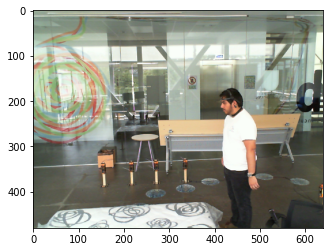

In [11]:
path_image = "Images/fall_img_8.png"
pred = prediction(path_image)
pred